<p style="font-size:300%; font-weight:bold">GridBallast Device Simulator</p>

Authors:

* Mario Bergés, Associate Professor, Carnegie Mellon University <marioberges@cmu.edu>

* Jingkun Gao, Research Assistant, Carnegie Mellon University <jingkung@andrew.cmu.edu>

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Executive-Summary" data-toc-modified-id="Executive-Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Executive Summary</a></div><div class="lev1 toc-item"><a href="#Device-Simulator" data-toc-modified-id="Device-Simulator-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Device Simulator</a></div><div class="lev2 toc-item"><a href="#Simple-One-node-TCL" data-toc-modified-id="Simple-One-node-TCL-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple One-node TCL</a></div><div class="lev3 toc-item"><a href="#A-specific-one-node-model:-Refrigerators" data-toc-modified-id="A-specific-one-node-model:-Refrigerators-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>A specific one-node model: Refrigerators</a></div><div class="lev3 toc-item"><a href="#Two-node-Model" data-toc-modified-id="Two-node-Model-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Two-node Model</a></div><div class="lev3 toc-item"><a href="#Deciding-between-the-one-and-two-node-models" data-toc-modified-id="Deciding-between-the-one-and-two-node-models-213"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Deciding between the one and two-node models</a></div><div class="lev4 toc-item"><a href="#One-node-model" data-toc-modified-id="One-node-model-2131"><span class="toc-item-num">2.1.3.1&nbsp;&nbsp;</span>One-node model</a></div><div class="lev4 toc-item"><a href="#Two-node-model" data-toc-modified-id="Two-node-model-2132"><span class="toc-item-num">2.1.3.2&nbsp;&nbsp;</span>Two-node model</a></div><div class="lev2 toc-item"><a href="#Deferrable-Plug-Loads" data-toc-modified-id="Deferrable-Plug-Loads-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Deferrable Plug Loads</a></div><div class="lev1 toc-item"><a href="#Simulation-Results" data-toc-modified-id="Simulation-Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulation Results</a></div><div class="lev2 toc-item"><a href="#One-node-EWH" data-toc-modified-id="One-node-EWH-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>One-node EWH</a></div><div class="lev2 toc-item"><a href="#Two-node-EWH" data-toc-modified-id="Two-node-EWH-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Two-node EWH</a></div><div class="lev2 toc-item"><a href="#One-node-Fridge" data-toc-modified-id="One-node-Fridge-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>One-node Fridge</a></div><div class="lev2 toc-item"><a href="#Deferrable-Load" data-toc-modified-id="Deferrable-Load-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Deferrable Load</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></div>

# Executive Summary

This document summarizes the theory and the implementation of the GridBallast Device Simulator developed under Award Number DE-AR0000705 for the Advanced Research Projects Agency - Energy (ARPA-E) NODES program. The simulator can be used to reproduce the power demand of two types of electrical loads: thermostatically controlled loads (TCLs) and deferrable plug-loads. For the TCLs, the simulator implements difference equations of the thermal dynamics assuming either a single or a stratified thermal mass. Two specific end-uses have been considered to specialize the simulation of TCLs: electric water heaters (EWHs) and refrigerators. Deferrable plug-loads, on the other hand, are modeled as a fixed or parametrized power demand pattern that can be interrupted at any time as long as the pattern is completed before a user-supplied deadline. Both types of loads can be controlled with a GridBallast controller that is also available in the simulator, and which directly controls the operational status (*on/off*) of the loads based on either: local grid frequency measurements, internal temperature or a ramping reserve participation request.

The document lays out the theory behind the TCL and deferrable plug-load models, as well as present the object-oriented code implementing the models. Following this, simulation results are shown as a first-order confirmation of the veracity and validity of the device simulator. 

# Device Simulator

The simulator can be used to reproduce the power demand of two types of electrical loads: thermostatically controlled loads (TCLs) and deferrable plug-loads. Both types of loads can be controlled with a GridBallast controller function that is also available in the simulator, and which directly controls the operational status (*on/off*) of the loads based on a combination of: local grid frequency measurements, internal temperature measurements, and ramping reserve participation requests.

For the TCLs, the simulator implements difference equations of the thermal dynamics assuming either a stratified or unstratified thermal storage element (e.g., an air chamber, or a water tank). For the unstratified case, we implement a *one-node* model assuming the thermal mass is fully mixed. For a more accurate representation of large water tanks and other TCL instances where full mixing does not always hold, a *two-node* model is also considered. Two specific end-uses have been considered to specialize the simulation of these TCLs: electric water heaters (EWHs) and refrigerators. The first two sub-sections that follow explain the theory of the one-node and two-node models.

Deferrable plug-loads, on the other hand, are modeled as a fixed or parametrized power demand pattern that can be interrupted at any time as long as it ends before a user-supplied deadline. The simulator thus takes as input a time-series of power demand values and a deadline for completing the pattern. More details about the theory and operation of this device simulator is provided at the end of this section.

## Simple One-node TCL

To simulate a simple, fully-mixed, unstratified thermal energy storage, we consider the differential equation describing the thermal balance between the storage element and its surrounding environment. This type of model has been widely used in the literature to simulate the behavior of water heaters and other TCLs [2,3,5,6]. Our specific model is directly inspired by the one in [1,2].


First, we assume that there are only two types of energy losses, resulting in a thermal power loss:

* Convection losses (in BTU/h): $\dot{Q}^{c}_t = \dfrac{SA}{R}[T_t-T^{amb}]$

* And, if the storage medium can be depleted with usage (e.g., water being drawn from a hot water tank), then there are other thermal power losses from the demand: $\dot{Q}^{d}_t = W_tC_p[T_t-T^{inlet}]$

Then there are power inputs, which we assume to be equal to the electrical power for cooling/heating the storage medium:$\dot{Q}^{p}_t=m_tP^r$

Thus, the sum of these losses and inputs, should be equal to the thermal capacitance of the tank:
$$C\dfrac{dT_t}{dt}=-\dot{Q}^{c}_t - \dot{Q}^{d}_t + \dot{Q}^{p}_t = -\dfrac{SA}{R}[T_t-T^{amb}]-W_tC_p[T_t-T^{inlet}]+m_tP^r$$

By solving the equation, we have
$$
T_{t+1} = \alpha_t T_{t}+(1-\alpha_t)(\frac{G}{G+B_t}T^{amb}+\frac{B_t}{G+B_t}T^{inlet}+\frac{m_tP^r}{G+B_t})
$$

where

$\alpha_t=e^{-\frac{\Delta t (G+B_t)}{C}}$ is an exponential coefficient,

$G = \frac{SA}{R}\, [BTU/h\cdot F]$, 

$B_t=W_t\times 8.3 C_p \, [BTU/h\cdot F]$, (8.3 is a factor to convert from lb/gal)

$C=8.3\times V_{tank}\times C_p \, [BTU/F]$ is the thermal capacitance of the thermal storage unit,

where any variable with a subscript $t$ depends on time, specifically

$T_{t+1}\, [F]$  is the internal temperature at time $t+1$,

$\Delta t\, [h]$  is the time step between $t+1$ and $t$, 

$SA \, [ft^2]$ is the surface area of the storage unit. For a cylindrical tank, then $SA=2r(r+h)$, where $r$ is the radius and $h$ is the height of the tank,

$R \, [h\cdot ft^2\cdot F/BTU]$ is the thermal resistance of the insulation,

$W_t \, [gal/h]$ is the water/air demand at time $t$, assuming it is constant value from $t$ to $t+1$,

$C_p \, [BTU/F\cdot lb]$ is the specific heat of the storage material (e.g., water),

$V_{tank} \, [gal]$ is the volumetric capacity of the storage unit,

$T^{amb} \, [F]$ is the ambient temperature,

$T^{inlet} \, [F]$ is the inlet temperature for the material used to replenished that which was lost to demand (e.g., inlet water temperature),

$m_t$ is the binary status of the load determined by checking whether the $T_t$ is within the setpoint deadband $[T^{s}-\frac{\delta}{2},T^{s}+\frac{\delta}{2}]$,

$T^s \, [F]$ is the setpoint and $\delta\, [F]$ is the thermostat deadband,

$P^{r} \, [BTU/h]$ is the rated power of the load.

This model has been implemented in **gridBallast/oneNodesimulator.py** as a class with methods to generate simulation results.

### A specific one-node model: Refrigerators

Refrigerators can be reliably modeled using the simple one-node model above. For simplicity, we assume the second loss term ($\dot{Q}^d_t$) is negligible (i.e., there is no demand). Thus, the evolution of their internal temperature can be easily derived, as explained below. It is worth noting that this type of models are widely used in the academic literature for simulating the behavior of aggregations of TCLs (e.g., [9,10]).

The convection losses (in BTU/h) of the fridge which increases the temperature:
$$\dot{Q}^c_t = \dfrac{1}{R^{'}}[T^{amb}-T_t]$$

The power input to the refrigerator's compressor (which we assume to be a constant value, whenever the compressor is *on*):
$$\dot{Q}^p_t=m_tP^r$$

Thus, the thermal dynamics of the water heater can be modeled as:
$$C\dfrac{dT_t}{dt}=\dfrac{1}{R^{'}}[T^{amb}-T_t]-m_tP^r$$

By solving the first-order differential equation, we have
$$
T_{t+1} = \alpha T_{t}+(1-\alpha)(T^{amb}-m_tT^{gain}) + \epsilon_t
$$

where

$T_{t+1}$ is the temperature at time $t+1$,

$\alpha=e^{-\frac{\Delta t}{C\cdot R^{'}}}$ (i.e., an exponential decay), and $\Delta t$ is the time step, $R^{'} [h \cdot F/BTU]$ is the thermal resistance, $C [BTU/F]$ is the thermal capacitance,

$T^{amb}$ is the ambient temperature,

Just like with the water heater, $m_t$ is the binary status of the refrigerator determined by checking whether the $T_t$ is within the deadband $[T^{s}-\frac{\delta}{2},T^{s}+\frac{\delta}{2}]$, or determined by the GridBallast controller,

$T^{gain}= R^{'}\cdot P^{r}$ is the thermal gain, and $R^{'}$ is the resistance, $P^{r}$ is the rated power of the device,

$\epsilon_{t} \sim \mathcal{N}(0,\hat\sigma^2) \, [F]$ are the error terms which, for now, we will ignore.


We have implemented the one-node refrigerator model in **gridBallast/TCLSimulator.py** as a class with methods to run simulations using the implementation.

### Two-node Model

Some TCLs present thermal stratification and thus cannot be reliably modeled using a simple one-node model. To resolve this, we also present a two-node model and develop it by considering the specific case of electric water heaters where water stratifies into top hot/ bottom cold layer during large water usage events. The model was inspired by other similar models in the literature, such as [4,7,8].

At the beginning of the simulation, we assume a one-node model of the whole water slug with uniformly distributed temperature (i.e., the water is well-mixed). After each time interval $\Delta t$, we check if the rate of change for the height of the hot-water slug (see the figure below) $\frac{dh}{dt} < 0$, which could be triggered by the change of water demand. Let's imagine a situation when a large amount of hot water is drawn from the tank. For the tank to remain full, cold water will be drawn from the inlet and it will fill the bottom cold layer. Thus, a stratification forms. When this model transition happens, we assume that the temperature for the upper layer is the same as the outlet temperature ($T^{upper}=T^{w}$), and that the temperature for the lower layer is the same as the inlet water temperature ($T^{lower}=T^{inlet}$). Using those values, a new height for the hot water slug ($h$) is calculated. When the water demand decreases, the two-node model will switch back to one-node model, as the height of hot water slug $h$ will increase and eventually be the height of the tank $H$. Thus, we switch to one-node model if if $h==H \& \frac{dh}{dt}>=0$.

![Two node model illustration](imgs/two_node.png)
Figure 1. Illustration of the thermal stratification inside the water tank. Adapted from [7].

In summary, after each time interval $\Delta t$, we calculate $\frac{dh}{dt}$ and new $h$ to decide whether to simulate using a one-node model or two-node model. For the one-node model, we can use the equation for one-node model in the previous section to calculate the change of water temperature as well as the power consumption. For the two-node, we consider the lower layer and upper layer separately and use a first-order differential equation to describe the thermal dynamics. This will be explained in more detail below.

### Deciding between the one and two-node models
We consider the height change of hot water slug. Denote $h$ as the height of hot water slug
$$
\frac{dh}{dt} = a + bh
$$
where
$$a=\frac{P^r+G\cdot(T^{amb}-T^{inlet})}{C\cdot(T^{upper}-T^{inlet})}H - \frac{\rho W_tC_p}{C}H$$
$$b=-\frac{G}{C}$$

The solution to the equation results in:
$$
h_{t+1} = \frac{e^{b\Delta t}(a+bh_t)-a}{b}
$$

Let's now denote $flag$ as a variable representing the type of model being employed: for the one-node model $flag=1$, and  for the two-node model $flag=2$. Some observations:

- If while $flag==1$, at some time point $\frac{dh}{dt}<0 \& \,H-h_{new} > h_{min}$, then we are effectively in two-node, so we let $flag=2$ ($h_{min}$ is to make sure the cold water slug has enough volume to trigger the lower thermostat);

- If while $flag==2$, at some point in time $h==H \& \frac{dh}{dt} >=0$, then we are effectively in one-node mode, so we let $flag=1$;

- otherwise, we stay in the previous state.

#### One-node model

The one-node model is very similar to the one previously described: 

$$
T_{t+1} = \alpha_t T_{t}+(1-\alpha_t)(\frac{G}{G+B_t}T^{amb}+\frac{B_t}{G+B_t}T^{inlet}+\frac{m_tP^r}{G+B_t})
$$

The same notation is used as before, with the only difference being that we force the upper and lower layer to have the same temperature value.
$T^{upper}=T^{lower}=T$ at time $t$.

#### Two-node model

The two-node model has some differences, mainly because there are two layers that need to be modeled separately, as well as their interaction. As is seen in the image above, we assume the width of the mixing layer is 0.

** Consider the lower layer to be L1 and the upper layer L2**

$$
C_p\rho L_1\frac{dT_1}{dt} = p_{1e} - p_{a1} - p_{21}
$$
$$
C_p\rho L_2\frac{dT_2}{dt} = p_{2e} - p_{a2} + p_{21} - p_{hw}
$$
where
$T_1=T^{lower}$ is the temperature of the lower layer,

$L_1 $ is the volume of the cold layer,

$T_2=T^{upper}$ is the temperature of the upper layer,

$L_2$ is the volume of the hot layer,

for $i=1,2$

$p_{ie}=P^r\cdot s_i$ is the thermal power generated by the heating element of corresponding layer,

$p_{ai}=\frac{SA_i}{R}(T_i - T^{amb})$ is the heat radiation from water inside the tank to the ambient air,

$p_{21}$ is the heat transferred from the cold layer to the hot layer, we assumed this energy is neglectable and being 0,

$p_{hw}=C_p\rho W_t \cdot (T_2-T^{inlet})$is the hot water consumption, representing the loss of the heat due to hot water being consumed.

When we plug in these variables we can rewrite it as follows:
$$\frac{dT_1}{dt}=a+bT_1=\frac{P^r\cdot s_1}{C_p\rho L_1}+\frac{SA_1 \cdot T^{amb}}{C_p \rho L_1 R} +(-\frac{SA_1}{C_p\rho L_1R})\cdot T1$$

$$\frac{dT_2}{dt}=a+bT_2=\frac{P^r\cdot s_2}{C_p\rho L_2}+\frac{SA_2 \cdot T^{amb}}{C_p \rho L_2 R} + \frac{W_t}{L_2} T^{inlet} - (\frac{SA_2}{C_p\rho L_2 R}+\frac{W_t}{L_2} )\cdot T_2$$

Both equations can be solved to produce:
$$T_{t+1}^i = \frac{e^{b\Delta t}(a+bT_t^i)-a}{b}$$

It is worth noting that the upper heating element and lower heating element will not be turned on at the same time. The upper heating element always has a higher priority to make sure the hot water slug is kept around the setpoint of the upper thermostat.

The specific variables/parameters of the model can be found below:

$C=\rho \times \frac{V_{tank}}{7.48}\times C_p \, [BTU/F]$ is the thermal mass of the tank,

$T_{t+1}\, [F]$  is the internal temperature at time $t+1$,
$T_t^{upper} /T2\, [F]$ is the temperature of the upper hot layer at time $t$,

$T_t^{lower}/T1\, [F]$ is the temperature of the lower cold layer at time $t$,

$\Delta t\, [h]$  is the time step between $t+1$ and $t$, should be a time constant, 

$SA \, [ft^2]$ is the surface area of the tank, normally $SA=2\pi r(r+H)$,

$SA_1 \, [ft^2]$ is the surface area of the lower water slug, normally $SA_1=2\pi r(r+H-h)$,

$SA_2 \, [ft^2]$ is the surface area of the upper water slug, normally $SA_2=2\pi r(r+h)$,

$r \, [ft]$ is the radius of the water tank,

$h \, [ft]$ is the height of the hot water slug,

$\Delta h\, [ft]$ is the hot water slug height change during certain time interval,

$H \, [ft]$ is the height of the water tank,

$h_{min}\, [ft]$ is to make sure the cold water slug has enough volume to trigger the lower thermostat, set to .2 for now,

$R \, [h\cdot ft^2\cdot F/BTU]$ is the thermal resistance of tank insulation,

$W_t \, [gal/h]$ is the water demand at time $t$, assuming it is constant value from $t$ to $t+1$,

$C_p \, [BTU/F\cdot lb]$ is the specific heat of water,

$\rho \, [lb/ft^3]$ is the density of the water,

$V_{tank} = 7.48\cdot \pi r^2H \, [gal]$ is the number of gallons of water (be careful about units),

$L_2 = \pi r^2 \cdot h \, [ft^3]$ is the volume of hot water,

$L_1 = \pi r^2 \cdot(H-h) \, [ft^3]$ is the volume of cold water,

$T^{amb} \, [F]$ is the ambient temperature,

$flag$ is the indicator of the one-node / two-node model,

$T^{inlet} \, [F]$ is the inlet water temperature,

$s_i$ is the binary status of the water heater determined by checking whether the $T_t$ is within the setpoint deadband $[T^{s}-\frac{\delta}{2},T^{s}+\frac{\delta}{2}]$,

$T^s \, [F]$ is the setpoint and $\delta\, [F]$ is the thermostat deadband,

$P^{r} \, [BTU/h]$ is the rated power of the EWH, notice in the case of two-node model, lower/upper heating element will have $P^r$ each but only one will be on at a time.

We have implemented this two-node model as a class in **gridBallast/twoNodesimulator.py**, with methods that can be called to generate simulation results.

## Deferrable Plug Loads

If one assumes that these loads have a common (or parametrizable) power consumption pattern during one duty cycle, and that this pattern can be interrupted and resumed at any point in time without penalty (i.e., the duty cycle is preemptive), then to simulate the power consumed by these type of loads a simulator only needs to be able to generate a pre-assigned power time-series for a duty-cycle (or a parametrized model for this), and the modify this time-series by inserting zeros at the time-locations where one wants to defer the load. For example, the figure below shows the power consumption pattern of a typical washer in the daytime. It was used twice in the day, one at 2:30PM, the other at 3:40PM. Thus, this record shows two duty-cycles of the appliance. Although there are subtle differences in the power consumption time series for these two cycles, overall they are very similar to each other.

![Power consumption of a typical washer in the daytime](imgs/tracebase_washer.png)

Controlling these types of loads means interrupting these cycles and resuming them at some point the future. To ensure quality of service, it is typical to think of these cycles as preemptive tasks that have a deadline (i.e., to the user, all that matters is that the cycle is completed by some time). This can be thought of as a very simple scheduling problem, where there is only a single preemptive task with a fixed deadline. To solve it, one needs to know the duration of the task (say, $T^{cycle}$). When the user starts the cycle (we may assume that cycles are user-initiated), he/she indicates the deadline. The scheduler then has some slack (the difference between the time to the deadline and $T^{cycle}$) to play with and can distribute that slack however it wishes. The GridBallast controller could act as one such scheduler, distributing the slack according to grid frequency values.

The input of the deferrable load simulator will be the duration of the load cycle $T^{cycle}$, the power consumption of the load during that cycle $\{P_i\}_{i=0,\cdots,T^{cycle}}$, the deadline for the cycle to complete $T^{max}$, along with the frequency information to trigger the GridBallast controller. We envision our simulator will have a number of pre-recorded power cycles that it can use for different deferrable loads.

The output of the deferrable load simulator will be $\{\hat{P}_i\}_{i=0,\cdots,T^{max}}$ to make sure the task (e.g., a washing cycle, or an Electric Vehicle battery charging) can be finished within $T^{max}$.

We implemented the deferrable plug model using the power draw of a washer combined with the schedule in **gridBallast/deferrableSimulator.py** where you can call the function inside to simulate the load of a washer.

# Simulation Results

In this section, we perform some simple simulation tests as a first-order validation of the device simulators. All the implementations have been organized in a Python library that can be found under the gridBallast folder. 

We start by importing the simulators from the gridBallast library.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from gridBallast.oneNodeSimulator import oneNodeSimulator
from gridBallast.twoNodeSimulator import waterheater
from gridBallast.TCLSimulator import TCLsimulator
from gridBallast.deferrableSimulator import deferrableSimulator

## One-node EWH

To start, we test one-node model. We simulate a period of 10 hours, at a resolution of 1 second. We assume that the water draw changes randomly every 15 minutes, and that grid frequency is also a Gaussian random variable with expected value of 60Hz and a standard deviation of 0.04Hz.

In [2]:
# initialize paras

# tank paras
tank_height = 3.9                        # [ft]
tank_radius = .66                        # [ft]
tank_hmin = .2                           # [ft]

# fixed paras
power_rate = 4500 * 3.412141633          # [BTU/h] Q_elec 
rho = 61.82                              # [lb/ft^3]
R = 80                                   # [ft^2 F h/BTU],tank thermal resistance 
Cp = 1                                   # [BTU/F lb]
f_low = 59.9                             # [Hz]
f_high = 60.1                            # [Hz]

# temp initial values
T_inlet = 65.                            # [F]
T_amb = 75.                              # [F]
T_setpoint = 120.                        # [F]
T_deadband = 2.                          # [F]
T_BOIL = 212.                            # [F] boiling temperature

# simulation paras
T_0 = 120                                # [F]
duration = 10                            # [h]
delta_t = 1./3600                        # [h]

# water demand data - use random demand
W_t = np.repeat(np.random.randint(50,size=duration*2),1/delta_t/2) 
# frequency data- use Gaussion distribution N(60,0.04^2)
F_t = np.random.normal(60,0.04,int(duration/delta_t))

**We start without the frequency control.**

In [3]:
T1,P1,_,_ = oneNodeSimulator(duration=duration,      # [h]
                             W_t=W_t,                # [gal/h]
                             F_t=F_t,                # [Hz]
                             # Tunable Paras
                             T_0=T_0,                # [F]
                             delta_t=delta_t,        # [h]
                             T_amb=T_amb,            # [F]
                             T_inlet=T_inlet,        # [F]
                             T_s=T_setpoint,         # [F]
                             deadband=T_deadband,    # [F]
                             m_0=0,                  # 
                             # Static Paras
                             r=tank_radius,          # [ft]
                             h=tank_height,          # [ft]
                             R=R,                   # [h ft^2 F/BTU]
                             Cp=Cp,                   # [BTU/F lb]
                             P_r=power_rate,         # [BTU/h]
                             enable_control=False,
                             f_low=f_low,            # [Hz]
                             f_high=f_high)          # [Hz])

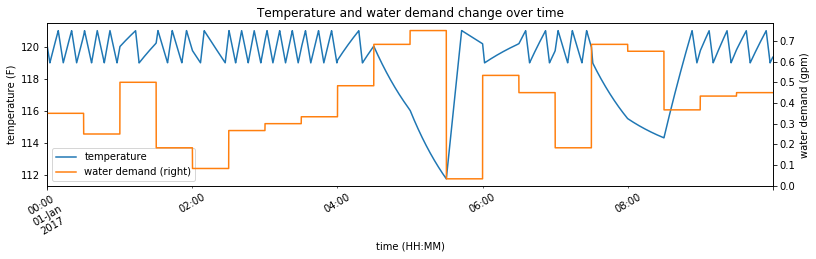

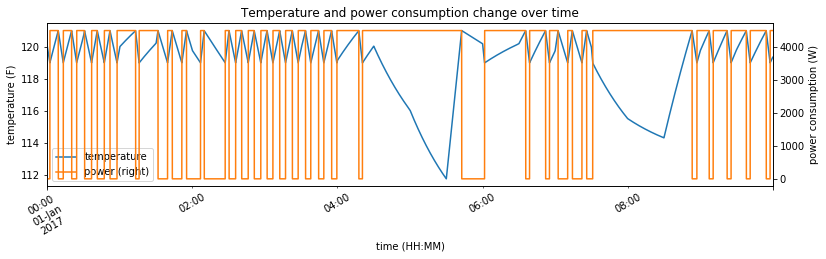

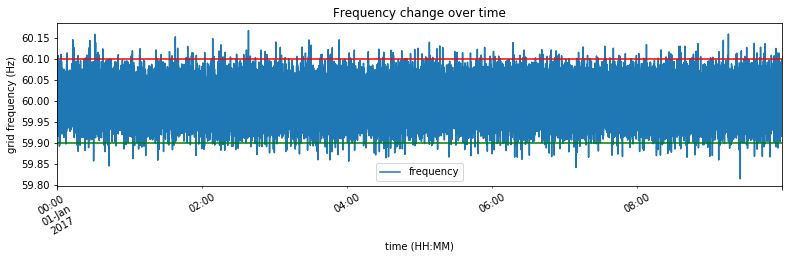

In [4]:
df_temp = pd.DataFrame(np.array([T1,P1,F_t,W_t/60.]).T,
                       index=pd.date_range('1/1/2017',
                       periods=duration/delta_t,
                       freq=str(int(delta_t*3600000))+'ms'),
                       columns=['temperature','power',
                                'frequency','water demand'])

# plot temperature and the water demand
plt.figure()
ax1 = df_temp[['temperature','water demand']].plot(
        secondary_y=['water demand'], 
        rot=30, figsize=(13,3),
        title='Temperature and water demand change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('water demand (gpm)')

# plot temperature and the power consumption
plt.figure()
ax1 = df_temp[['temperature','power']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Temperature and power consumption change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('power consumption (W)')

# plot frequency change over time
plt.figure()
ax2 = df_temp[['frequency']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Frequency change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('grid frequency (Hz)')
ax2.axhline(y=f_high,c='red')
ax2.axhline(y=f_low,c='green')

**Now we enable the GridBallast Controller, which will turn on/off load depending on the grid frequency**

In [5]:
T1,P1,_,_ = oneNodeSimulator(duration=duration,      # [h]
                             W_t=W_t,                # [gal/h]
                             F_t=F_t,                # [Hz]
                             # Tunable Paras
                             T_0=T_0,                # [F]
                             delta_t=delta_t,        # [h]
                             T_amb=T_amb,            # [F]
                             T_inlet=T_inlet,        # [F]
                             T_s=T_setpoint,         # [F]
                             deadband=T_deadband,    # [F]
                             m_0=0,                  # 
                             # Static Paras
                             r=tank_radius,          # [ft]
                             h=tank_height,          # [ft]
                             R=R,                   # [h ft^2 F/BTU]
                             Cp=Cp,                   # [BTU/F lb]
                             P_r=power_rate,         # [BTU/h]
                             enable_control=True,
                             f_low=f_low,            # [Hz]
                             f_high=f_high)          # [Hz])

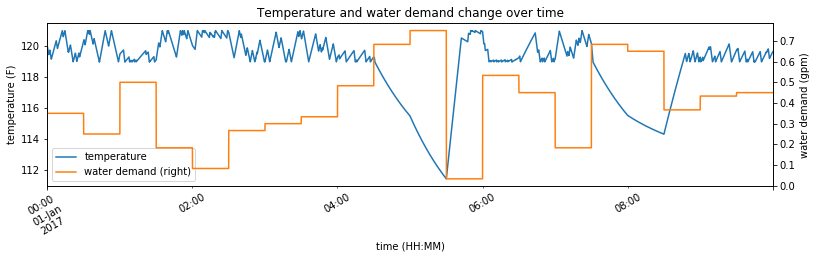

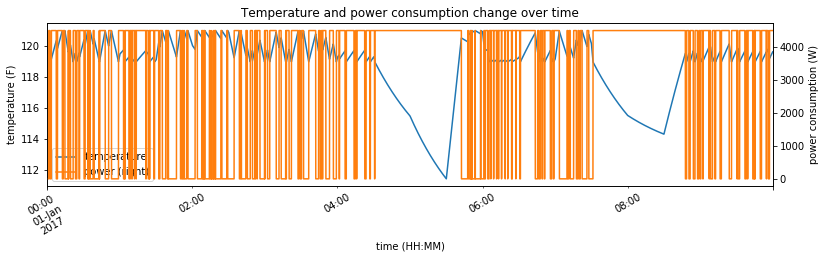

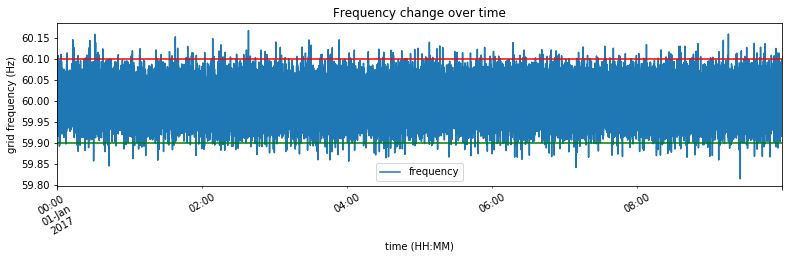

In [6]:
df_temp = pd.DataFrame(np.array([T1,P1,F_t,W_t/60.]).T,
                       index=pd.date_range('1/1/2017',
                       periods=duration/delta_t,
                       freq=str(int(delta_t*3600000))+'ms'),
                       columns=['temperature','power',
                                'frequency','water demand'])

# plot temperature and the water demand
plt.figure()
ax1 = df_temp[['temperature','water demand']].plot(
        secondary_y=['water demand'], 
        rot=30, figsize=(13,3),
        title='Temperature and water demand change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('water demand (gpm)')

# plot temperature and the power consumption
plt.figure()
ax1 = df_temp[['temperature','power']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Temperature and power consumption change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('power consumption (W)')

# plot frequency change over time
plt.figure()
ax2 = df_temp[['frequency']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Frequency change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('grid frequency (Hz)')
ax2.axhline(y=f_high,c='red')
ax2.axhline(y=f_low,c='green')

## Two-node EWH

We test two-node model with frequency control, by using the same input parameters used by one-node such that we can compare the performance.

In [7]:
wh = waterheater(duration=duration,                      # [h]
                 W_t = W_t,
                F_t = F_t, 
                # simulation paras
                T_0 = T_0,                               # [F]
                delta_t = delta_t,                       # [h]
                # static paras
                tank_height = tank_height,               # [ft]
                tank_radius = tank_radius,               # [ft]
                tank_top_to_upperHeatingPos = tank_hmin, # [ft]
                # fixed paras
                power_rate = power_rate,                 # [BTU/h] Q_elec
                rho = rho,                               # [lb/ft^3]
                R = R,                                   # [ft^2 F h/BTU]
                Cp = Cp,                                 # [BTU/F lb]
                f_low = f_low,                           # [Hz]
                f_high = f_high,                         # [Hz]
                # temperature
                T_inlet = T_inlet,                       # [F]
                T_amb = T_amb,                           # [F]
                T_setpoint = T_setpoint,                 # [F]
                T_deadband = T_deadband,                 # [F]
                T_BOIL = T_BOIL,                         # [F] boiling temperature
                 )

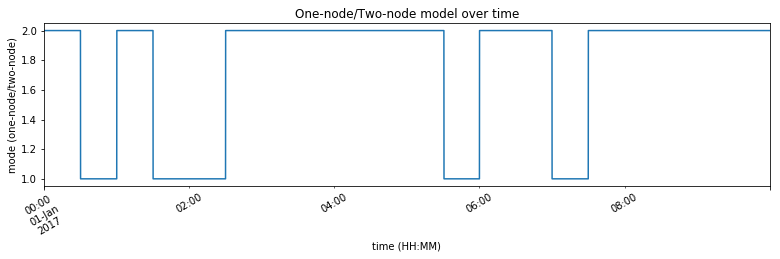

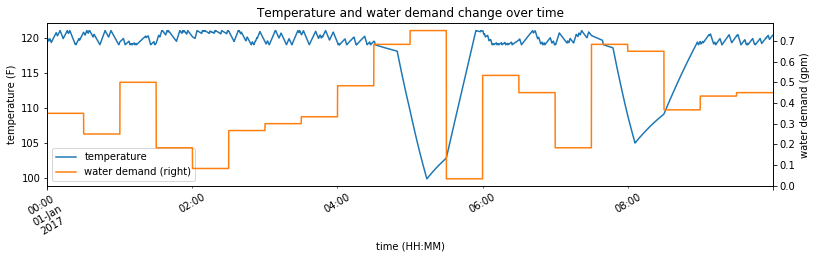

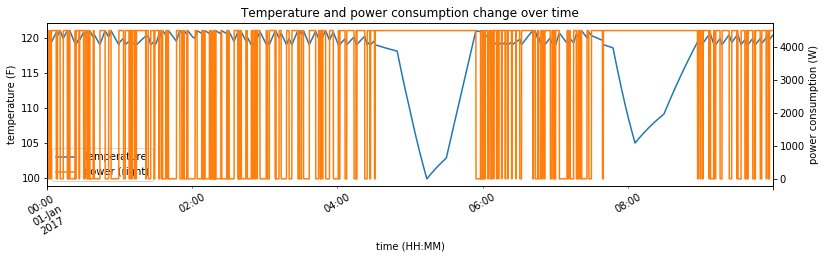

In [8]:
wh.simulate(True)

df_temp = pd.DataFrame(np.array([wh.FLAG_t,wh.T_t,
                                 wh.water_demand/60,
                                 wh.P_t,wh.Ft]).T,
                       index=pd.date_range('1/1/2017',
                            periods=wh.duration/wh.delta_t,
                            freq=str(int(wh.delta_t*3600000))+'ms'),
                       columns=['mode','temperature',
                                'water demand','power',
                                'grid frequency (Hz)'])

# plot one-/two- node mode
plt.figure()
ax0=df_temp['mode'].plot(title='One-node/Two-node model over time',
                         rot=30, figsize=(13,3))
ax0.set_xlabel('time (HH:MM)')
ax0.set_ylabel('mode (one-node/two-node)')

# plot temperature and water demand
plt.figure()
ax1 = df_temp[['temperature','water demand']].plot(
            secondary_y=['water demand'],
            rot=30,figsize=(13,3),
            title='Temperature and water demand change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('water demand (gpm)')

# plot temperature and power consumpiton
plt.figure()
ax2 = df_temp[['temperature','power']].plot(
        secondary_y=['power'],
        rot=30,figsize=(13,3),
        title='Temperature and power consumption change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('temperature (F)')
ax2.right_ax.set_ylabel('power consumption (W)')

We now compare the temperatures of the one and two node models

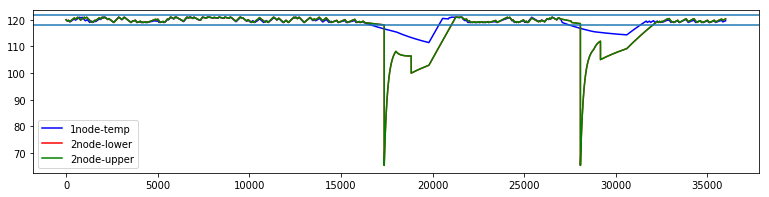

In [9]:
# We compare the temperature of one-/two- node models
plt.figure(figsize=(13,3))
plt.plot(T1,'b')

plt.plot(wh.Tlower_t,'r')
plt.plot(wh.Tupper_t,'g')
plt.legend(['1node-temp','2node-lower','2node-upper'])
plt.axhline(118)
plt.axhline(122)

From the above figure, we can see that 2-node model provides outlet water within the thermal band range more often than one-node model. The advantage lies in that in the case of two-node model, only upper water slug needs to be heated up instead of the whole tank of water. As a result, it is faster to heat up the outlet water to the required setpoint.

**Let's further try the simulation without control** for two-node model and see what the power consumption patterns look like.

In [10]:
wh2 = waterheater(duration=duration,                      # [h]
                 W_t = W_t,
                F_t = F_t, 
                # simulation paras
                T_0 = T_0,                               # [F]
                delta_t = delta_t,                       # [h]
                # static paras
                tank_height = tank_height,               # [ft]
                tank_radius = tank_radius,               # [ft]
                tank_top_to_upperHeatingPos = tank_hmin, # [ft]
                # fixed paras
                power_rate = power_rate,                 # [BTU/h] Q_elec
                rho = rho,                               # [lb/ft^3]
                R = R,                                   # [ft^2 F h/BTU]
                Cp = Cp,                                 # [BTU/F lb]
                f_low = f_low,                           # [Hz]
                f_high = f_high,                         # [Hz]
                # temperature
                T_inlet = T_inlet,                       # [F]
                T_amb = T_amb,                           # [F]
                T_setpoint = T_setpoint,                 # [F]
                T_deadband = T_deadband,                 # [F]
                T_BOIL = T_BOIL,                         # [F] boiling temperature
                 )


wh2.simulate(False)

df_temp2 = pd.DataFrame(np.array([wh2.FLAG_t,wh2.T_t,
                                  wh2.water_demand/60,
                                  wh2.P_t,wh2.Ft]).T,
                        index=pd.date_range('1/1/2017',
                            periods=wh2.duration/wh2.delta_t,
                            freq=str(int(wh2.delta_t*3600000))+'ms'),
                        columns=['mode','temperature',
                                 'water demand','power',
                                 'grid frequency (Hz)'])


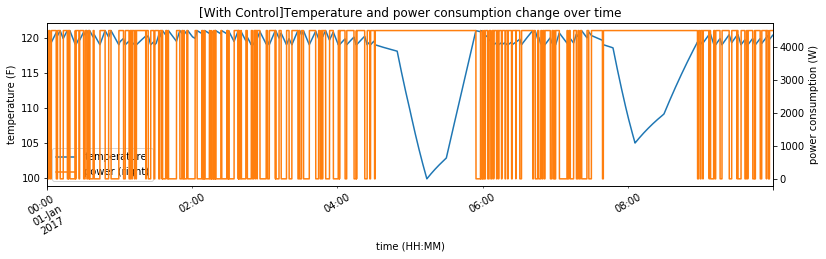

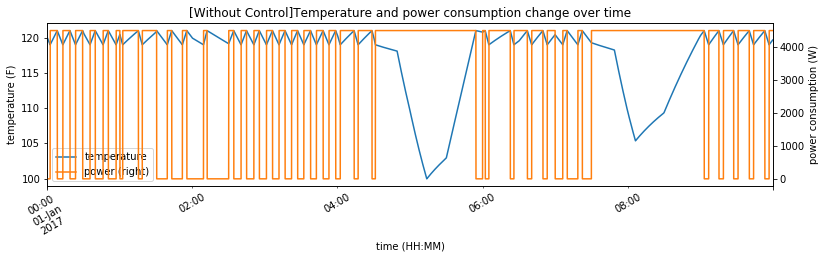

In [13]:
plt.figure()
ax1 = df_temp[['temperature','power']].plot(
        secondary_y=['power'],
        rot=30,figsize=(13,3),
 title='[With Control]Temperature and power consumption change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('power consumption (W)')

plt.figure()

ax2 = df_temp2[['temperature','power']].plot(
    secondary_y=['power'],
    rot=30,figsize=(13,3),
 title='[Without Control]Temperature and power consumption change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('temperature (F)')
ax2.right_ax.set_ylabel('power consumption (W)')

**To further understand the capacity of the two-node simulator, we run the following simulation experiments:**
- duration:10h, interval: 1 min, random water demand, random grid frequency with control
- duration: 1h, interval: 1 s, random water demand, random grid frequency with control
- duration:1 min, interval: 16 ms, constant water demand, random grid frequency with control

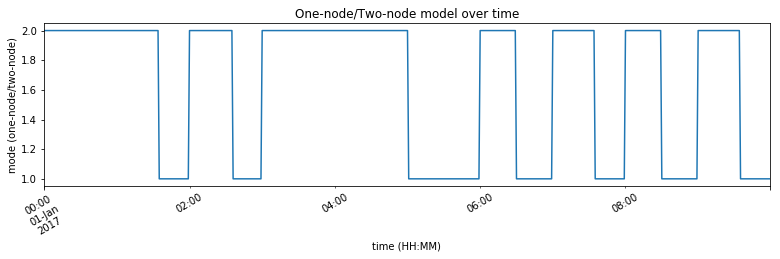

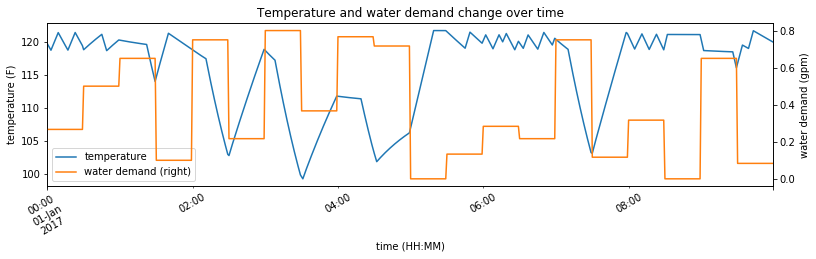

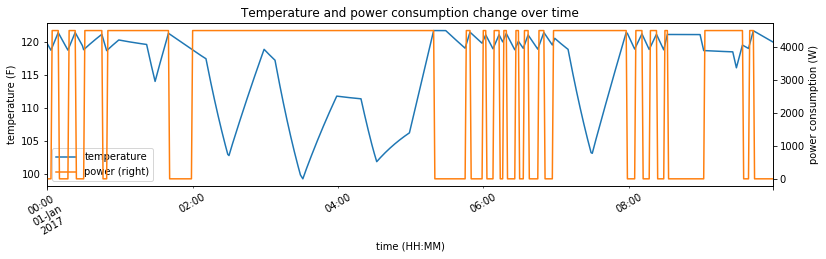

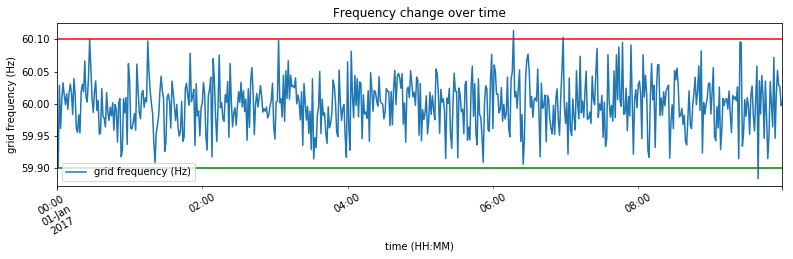

In [14]:
# duration:10h, interval: 1 min, random water demand, random grid frequency with control

duration = 10                            # [h]
delta_t = 1./60                          # [h]

# water demand data - use random demand
W_t = np.repeat(np.random.randint(50,size=duration*2),1/delta_t/2) 
# frequency data- use Gaussion distribution N(60,0.04^2)
F_t = np.random.normal(60,0.04,int(duration/delta_t))

wh2 = waterheater(duration=duration,                     # [h]
                 W_t = W_t,
                F_t = F_t, 
                # simulation paras
                T_0 = T_0,                               # [F]
                delta_t = delta_t,                       # [h]
                # static paras
                tank_height = tank_height,               # [ft]
                tank_radius = tank_radius,               # [ft]
                tank_top_to_upperHeatingPos = tank_hmin, # [ft]
                # fixed paras
                power_rate = power_rate,                 # [BTU/h] Q_elec
                rho = rho,                               # [lb/ft^3]
                R = R,                                   # [ft^2 F h/BTU]
                Cp = Cp,                                 # [BTU/F lb]
                f_low = f_low,                           # [Hz]
                f_high = f_high,                         # [Hz]
                # temperature
                T_inlet = T_inlet,                       # [F]
                T_amb = T_amb,                           # [F]
                T_setpoint = T_setpoint,                 # [F]
                T_deadband = T_deadband,                 # [F]
                T_BOIL = T_BOIL,                         # [F] boiling temperature
                 )


wh2.simulate(True)

df_temp = pd.DataFrame(np.array([wh2.FLAG_t,wh2.T_t,
                                 wh2.water_demand/60,
                                 wh2.P_t,wh2.Ft]).T,
                       index=pd.date_range('1/1/2017',
                              periods=wh2.duration/wh2.delta_t,
                              freq=str(int(wh2.delta_t*3600000))+'ms'),
                       columns=['mode','temperature',
                                'water demand','power',\
                                'grid frequency (Hz)'])
# plot one-/two- node mode
plt.figure()
ax0=df_temp['mode'].plot(title='One-node/Two-node model over time',
                         rot=30, figsize=(13,3))
ax0.set_xlabel('time (HH:MM)')
ax0.set_ylabel('mode (one-node/two-node)')

# plot temperature and water demand
plt.figure()
ax1 = df_temp[['temperature','water demand']].plot(
                  secondary_y=['water demand'],
                  rot=30,figsize=(13,3),
    title='Temperature and water demand change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('water demand (gpm)')

# plot temperature and power consumpiton
plt.figure()
ax2 = df_temp[['temperature','power']].plot(
                secondary_y=['power'],
                rot=30,figsize=(13,3),
    title='Temperature and power consumption change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('temperature (F)')
ax2.right_ax.set_ylabel('power consumption (W)')

# plot frequency change over time
plt.figure()
ax3 = df_temp[['grid frequency (Hz)']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Frequency change over time')
ax3.set_xlabel('time (HH:MM)')
ax3.set_ylabel('grid frequency (Hz)')
ax3.axhline(y=f_high,c='red')
ax3.axhline(y=f_low,c='green')

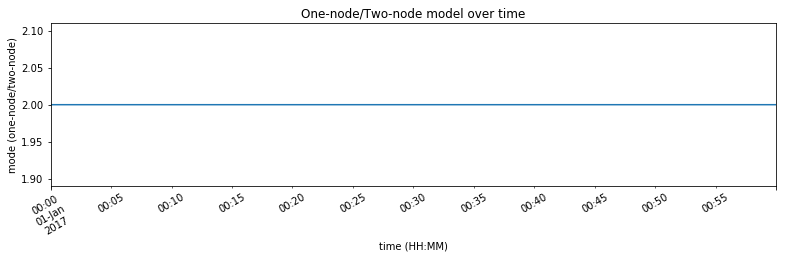

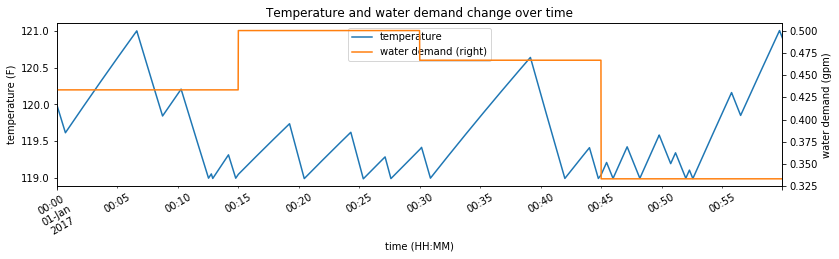

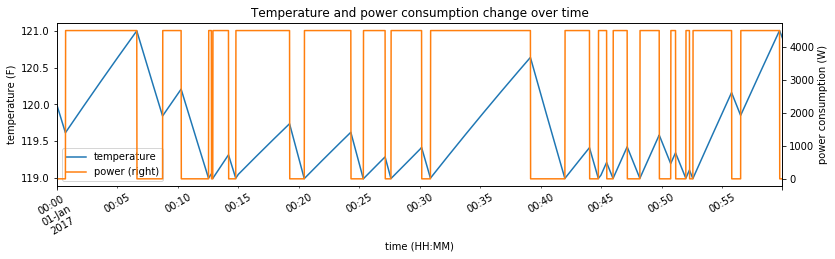

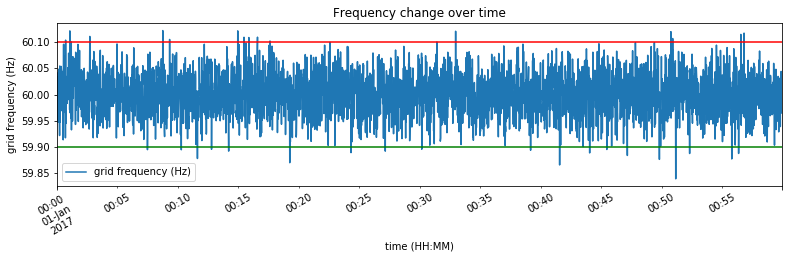

In [15]:
# duration: 1h, interval: 1 s, random water demand, random grid frequency with control

duration = 1                             # [h]
delta_t = 1./3600                        # [h]

# water demand data - use random demand
W_t = np.repeat(np.random.randint(50,size=duration*4),1/delta_t/4) 
# frequency data- use Gaussion distribution N(60,0.04^2)
F_t = np.random.normal(60,0.04,int(duration/delta_t))

wh2 = waterheater(duration=duration,                     # [h]
                 W_t = W_t,
                F_t = F_t, 
                # simulation paras
                T_0 = T_0,                               # [F]
                delta_t = delta_t,                       # [h]
                # static paras
                tank_height = tank_height,               # [ft]
                tank_radius = tank_radius,               # [ft]
                tank_top_to_upperHeatingPos = tank_hmin, # [ft]
                # fixed paras
                power_rate = power_rate,                 # [BTU/h] Q_elec
                rho = rho,                               # [lb/ft^3]
                R = R,                                   # [ft^2 F h/BTU]
                Cp = Cp,                                 # [BTU/F lb]
                f_low = f_low,                           # [Hz]
                f_high = f_high,                         # [Hz]
                # temperature
                T_inlet = T_inlet,                       # [F]
                T_amb = T_amb,                           # [F]
                T_setpoint = T_setpoint,                 # [F]
                T_deadband = T_deadband,                 # [F]
                T_BOIL = T_BOIL,                         # [F] boiling temperature
                 )


wh2.simulate(True)

df_temp = pd.DataFrame(np.array([wh2.FLAG_t,wh2.T_t,
                                 wh2.water_demand/60,
                                 wh2.P_t,wh2.Ft]).T,
                       index=pd.date_range('1/1/2017',
                              periods=wh2.duration/wh2.delta_t,
                              freq=str(int(wh2.delta_t*3600000))+'ms'),
                       columns=['mode','temperature',
                                'water demand','power',\
                                'grid frequency (Hz)'])
# plot one-/two- node mode
plt.figure()
ax0=df_temp['mode'].plot(title='One-node/Two-node model over time',
                         rot=30, figsize=(13,3))
ax0.set_xlabel('time (HH:MM)')
ax0.set_ylabel('mode (one-node/two-node)')

# plot temperature and water demand
plt.figure()
ax1 = df_temp[['temperature','water demand']].plot(
                  secondary_y=['water demand'],
                  rot=30,figsize=(13,3),
    title='Temperature and water demand change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('water demand (gpm)')

# plot temperature and power consumpiton
plt.figure()
ax2 = df_temp[['temperature','power']].plot(
                secondary_y=['power'],
                rot=30,figsize=(13,3),
    title='Temperature and power consumption change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('temperature (F)')
ax2.right_ax.set_ylabel('power consumption (W)')

# plot frequency change over time
plt.figure()
ax3 = df_temp[['grid frequency (Hz)']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Frequency change over time')
ax3.set_xlabel('time (HH:MM)')
ax3.set_ylabel('grid frequency (Hz)')
ax3.axhline(y=f_high,c='red')
ax3.axhline(y=f_low,c='green')

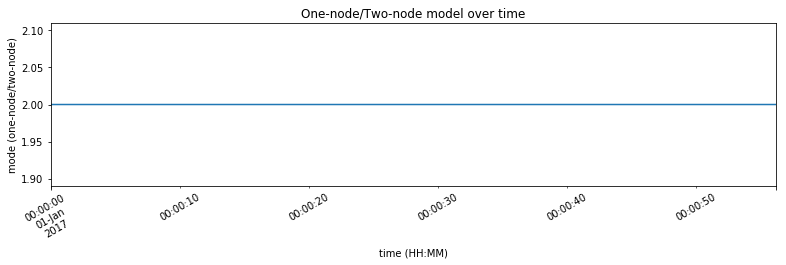

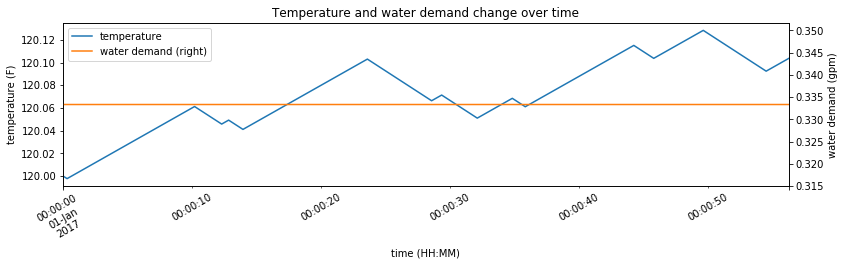

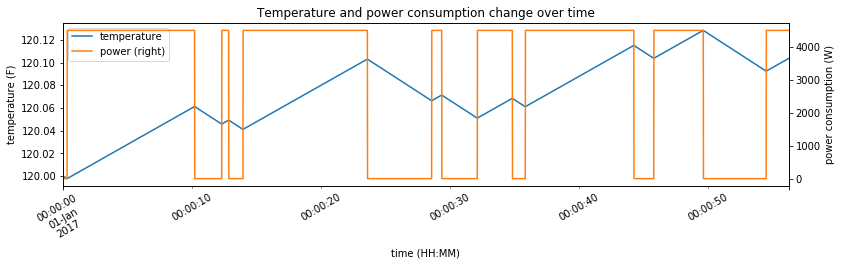

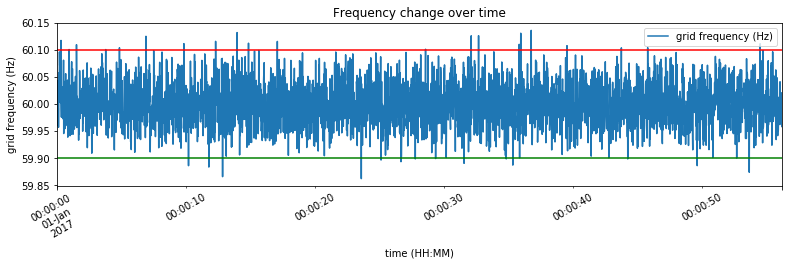

In [16]:
# duration:1 min, interval: 16 ms, constant water demand, random grid frequency with control

duration = 1./60                             # [h]
delta_t = 1./3600/1000*16                    # [h]

# water demand data - use random demand
W_t = np.ones(int(duration/delta_t))*20 
# frequency data- use Gaussion distribution N(60,0.04^2)
F_t = np.random.normal(60,0.04,int(duration/delta_t))

wh2 = waterheater(duration=duration,                     # [h]
                 W_t = W_t,
                F_t = F_t, 
                # simulation paras
                T_0 = T_0,                               # [F]
                delta_t = delta_t,                       # [h]
                # static paras
                tank_height = tank_height,               # [ft]
                tank_radius = tank_radius,               # [ft]
                tank_top_to_upperHeatingPos = tank_hmin, # [ft]
                # fixed paras
                power_rate = power_rate,                 # [BTU/h] Q_elec
                rho = rho,                               # [lb/ft^3]
                R = R,                                   # [ft^2 F h/BTU]
                Cp = Cp,                                 # [BTU/F lb]
                f_low = f_low,                           # [Hz]
                f_high = f_high,                         # [Hz]
                # temperature
                T_inlet = T_inlet,                       # [F]
                T_amb = T_amb,                           # [F]
                T_setpoint = T_setpoint,                 # [F]
                T_deadband = T_deadband,                 # [F]
                T_BOIL = T_BOIL,                         # [F] boiling temperature
                 )


wh2.simulate(True)

df_temp = pd.DataFrame(np.array([wh2.FLAG_t,wh2.T_t,
                                 wh2.water_demand/60,
                                 wh2.P_t,wh2.Ft]).T,
                       index=pd.date_range('1/1/2017',
                              periods=wh2.duration/wh2.delta_t,
                              freq=str(int(wh2.delta_t*3600000))+'ms'),
                       columns=['mode','temperature',
                                'water demand','power',\
                                'grid frequency (Hz)'])
# plot one-/two- node mode
plt.figure()
ax0=df_temp['mode'].plot(title='One-node/Two-node model over time',
                         rot=30, figsize=(13,3))
ax0.set_xlabel('time (HH:MM)')
ax0.set_ylabel('mode (one-node/two-node)')

# plot temperature and water demand
plt.figure()
ax1 = df_temp[['temperature','water demand']].plot(
                  secondary_y=['water demand'],
                  rot=30,figsize=(13,3),
    title='Temperature and water demand change over time')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('water demand (gpm)')

# plot temperature and power consumpiton
plt.figure()
ax2 = df_temp[['temperature','power']].plot(
                secondary_y=['power'],
                rot=30,figsize=(13,3),
    title='Temperature and power consumption change over time')
ax2.set_xlabel('time (HH:MM)')
ax2.set_ylabel('temperature (F)')
ax2.right_ax.set_ylabel('power consumption (W)')

# plot frequency change over time
plt.figure()
ax3 = df_temp[['grid frequency (Hz)']].plot(secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='Frequency change over time')
ax3.set_xlabel('time (HH:MM)')
ax3.set_ylabel('grid frequency (Hz)')
ax3.axhline(y=f_high,c='red')
ax3.axhline(y=f_low,c='green')

## One-node Fridge
We also look at the behaviour of our refrigerator simulator (a simple one-node TCL model without demand). We consider the case where GridBallast is enabled, as well as disabled. We simulate an hour of operation and, again, assume that the grid frequency is a random Gaussian.

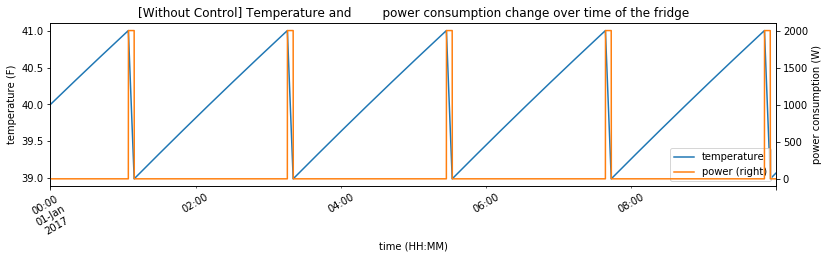

In [17]:
# we simulate for 1h, the time step is 1s
duration = 10
T_0 = 40.
step = 1./3600
C = 263
R = .1
T_amb = 65
P_r = 2000 * 3.4121
T_s = 40
deadband = 2.

T1,P_t, temp = TCLsimulator(duration, 
                            T_0=T_0,
                            delta_t=step,
                            C=C,
                            R=R,
                            T_amb=T_amb,
                            P_r=P_r,
                            T_s=T_s,
                            deadband=deadband
                           )
df_temp = pd.DataFrame(np.array([T1,P_t]).T,
                       index=pd.date_range('1/1/2017',
                       periods=duration/step,freq='s'),
                       columns=['temperature','power'])

# plot temperature and the power consumption
plt.figure()
ax1 = df_temp[['temperature','power']].plot(
        secondary_y=['power'], 
        rot=30, figsize=(13,3),
 title='[Without Control] Temperature and power consumption change over time of the fridge')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('power consumption (W)')

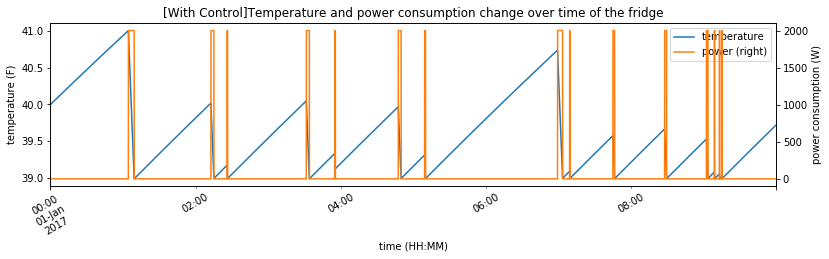

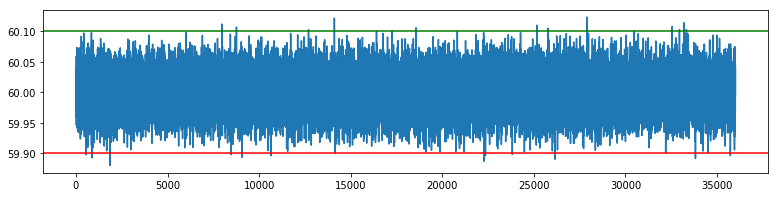

In [18]:
# with control
F_t = np.random.normal(60,0.03,int(duration/step))
f_low = 59.9
f_high = 60.1

T1,P_t, temp = TCLsimulator(duration, 
                            T_0=T_0,
                            delta_t=step,
                            C=C,
                            R=R,
                            T_amb=T_amb,
                            P_r=P_r,
                            T_s=T_s,
                            deadband=deadband,
                            enable_control=True,
                            F_t=F_t,
                            f_low=f_low,
                            f_high=f_high
                           )
df_temp = pd.DataFrame(np.array([T1,P_t]).T,
                       index=pd.date_range('1/1/2017',
                       periods=duration/step,freq='s'),
                       columns=['temperature','power'])

# plot temperature and the power consumption
plt.figure()
ax1 = df_temp[['temperature','power']].plot(
        secondary_y=['power'], 
        rot=30, figsize=(13,3),
        title='[With Control]Temperature and power consumption change over time of the fridge')
ax1.set_xlabel('time (HH:MM)')
ax1.set_ylabel('temperature (F)')
ax1.right_ax.set_ylabel('power consumption (W)')


plt.figure(figsize=(13,3))
plt.plot(F_t)
plt.axhline(y=f_low,c='red')
plt.axhline(y=f_high,c='green')

## Deferrable Load

We now look at the behavior of our deferrable plug-load simulator. We specifically instantiate it using the power draw pattern of a clothes washer. We consider one washing cycle lasting for one hour, and assume the user gave the washer a deadline of 3 hours to complete the cycle.

We take the power data from one cycle of a real washer and the grid frequency data from [FNET/GreidEye](http://fnetpublic.utk.edu/tabledisplay.html).



In [19]:
step = 1./3600                    # [hour] ,consider second as the time tick
T_cycle = 1                       # number of hours for a cycle
T_max = 3                         # number of max acceptable hours for a cycle
P_cycle = pd.read_csv('sample_washer.csv',
                      parse_dates=True,
                      index_col=0,
                      names=['power(W)']).values
P_cycle = P_cycle[1:].reshape(int(T_cycle/step))
F_t = np.genfromtxt('sample_freq.csv')
F_t = F_t[:int(T_max/step)]

# P_cycle and F_t should be alighned with the time ticks of a cycle
f_low = 59.99
f_high = 60.01

oldP,newP = deferrableSimulator(T_cycle,
                        T_max,
                        step,
                        P_cycle,
                        F_t,
                        f_low,
                        f_high)

df_defer = pd.DataFrame(np.array([oldP,newP,F_t]).T,
                        columns=['old pattern(W)',
                        'new pattern(W)','frequency(Hz)'])

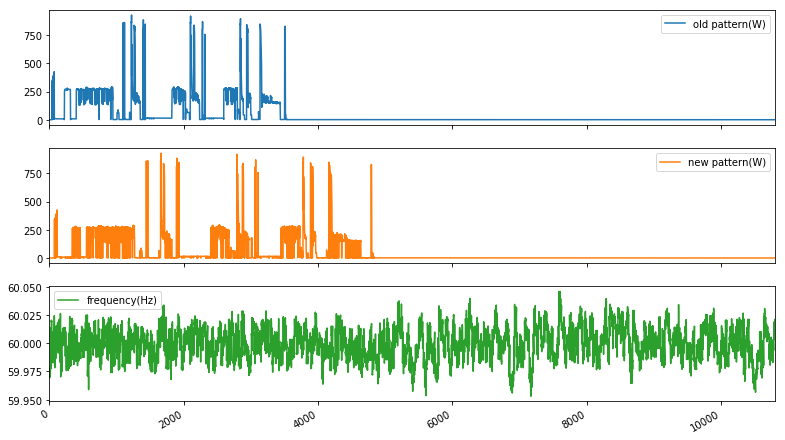

In [20]:
ax = df_defer.plot(subplots=True,sharex=True,figsize=(13,8), layout=(3,1))
# ax[2].axhline(y=f_high,c='red')
# ax[2].axhline(y=f_low,c='green')
# plt.show()

The top pattern represents the original power consumption of the washer over time. The middle pattern represents the new power consumption patterns, which responds to grid frequency (shown in the bottom plot).

# References
[1] Gustafson, M. W., Baylor, J. S., & Epstein, G. (1993). Direct water heater load control-estimating program effectiveness using an engineering model. IEEE Transactions on Power Systems, 8(1), 137–143. http://doi.org/10.1109/59.221259

[2] Dolan, P. S., Nehrir, M. H., & Gerez, V. (1996). Development of a Monte Carlo based aggregate model for residential electric water heater loads. Electric Power Systems Research, 36(1), 29–35. http://doi.org/10.1016/0378-7796(95)01011-4

[3] Lu, N., Chassin, D. P., & Widergren, S. E. (2005). Modeling uncertainties in aggregated thermostatically controlled loads using a state queueing model. IEEE Transactions on Power Systems, 20(2), 725–733. http://doi.org/10.1109/TPWRS.2005.846072

[4] Taylor, Z. T., Gowri, K., & Katipamula, S. (2008). GridLAB-D Technical Support Document: Residential End-Use Module Version 1.0. Richland, WA. Retrieved from http://www.osti.gov/servlets/purl/939875-bSyqT4/

[5] Paull, L., Li, H., & Chang, L. (2010). A novel domestic electric water heater model for a multi-objective demand side management program. Electric Power Systems Research, 80(12), 1446–1451. http://doi.org/10.1016/j.epsr.2010.06.013

[6] Moreau, A. (2011). Control Strategy for Domestic Water Heaters during Peak Periods and its Impact on the Demand for Electricity. Energy Procedia, 12, 1074–1082. http://doi.org/10.1016/j.egypro.2011.10.140

[7] Kondoh, J., Lu, N., & Hammerstrom, D. J. (2011). An evaluation of the water heater load potential for providing regulation service. In 2011 IEEE Power and Energy Society General Meeting (pp. 1–8). IEEE. http://doi.org/10.1109/PES.2011.6039149

[8] Ruisheng Diao, Yu Zhang, & Samaan, N. (2012). Electric water heater modeling and control strategies for demand response. In 2012 IEEE Power and Energy Society General Meeting (pp. 1–8). IEEE. http://doi.org/10.1109/PESGM.2012.6345632

[9] Kara, E. C., Berges, M., Krogh, B., & Kar, S. (2012). Using smart devices for system-level management and control in the smart grid: A reinforcement learning framework. In 2012 IEEE Third International Conference on Smart Grid Communications (SmartGridComm) (pp. 85–90). IEEE. http://doi.org/10.1109/SmartGridComm.2012.6485964

[10] Kara, E. C., Bergés, M., & Hug, G. (2014). Modeling Thermostatically Controlled Loads to Engage Households in the Smart Grid: Lessons Learned from Residential Refrigeration Units. In Computing in Civil and Building Engineering (2014) (pp. 2032–2039). Reston, VA: American Society of Civil Engineers. http://doi.org/10.1061/9780784413616.252